# The dataset

We will explore regression models using a standard bencharking dataset, the AMES Housing data. This comprises data about individual housing property in AMES, Iowa, USA, from 2006-2010. More information on the data set can be found here: 
Dataset description -  http://jse.amstat.org/v19n3/decock.pdf
Dataset documentation http://jse.amstat.org/v19n3/decock/DataDocumentation.txt
The actual dataset in text, tab-separated format: http://jse.amstat.org/v19n3/decock/AmesHousing.txt

In [1]:
import pandas as pd

We will not use the complete set of attributes in the dataset but we will downselect specific ones: 

Overall Qual (Ordinal): Rates the overall material and finish of the house
       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average
       5	Average
       4	Below Average
       3	Fair
       2	Poor
       1	Very Poor
       
Overall Cond (Ordinal): Rates the overall condition of the house
       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average	
       5	Average
       4	Below Average	
       3	Fair
       2	Poor
       1	Very Poor 
       
Gr Liv Area (Continuous): Above grade (ground) living area square feet

entral Air (Nominal): Central air conditioning
       N	No
       Y	Yes

total Bsmt SF (Continuous): Total square feet of basement area

SalePrice (Continuous): Sale price in $$

In [2]:
columns = ['Overall Qual', 'Overall Cond', 'Gr Liv Area', 'Central Air', 'Total Bsmt SF', 'SalePrice']

In [3]:
df = pd.read_csv('http://jse.amstat.org/v19n3/decock/AmesHousing.txt',sep='\t',usecols=columns)

We can also read the data set locally

In [49]:
df = pd.read_csv('AmesHousing.txt',sep='\t',usecols=columns)

Let's inspect the first 5 lines of the dataframe populated with the data

In [4]:
df.head()

,Overall Qual,Overall Cond,Total Bsmt SF,Central Air,Gr Liv Area,SalePrice
0,6,5,1080.0,Y,1656,215000
1,5,6,882.0,Y,896,105000
2,6,6,1329.0,Y,1329,172000
3,7,5,2110.0,Y,2110,244000
4,5,5,928.0,Y,1629,189900


All attributes above are numerical, apart from Central Air

Let's inspect also the shape / dimensions of the dataset

In [5]:
df.shape

(2930, 6)

We can convert the Central Air varariable to a numerical one by mapping 'N' values to 0 and 'Y' values to 1 and inspect the data again.

In [6]:
df['Central Air'] = df['Central Air'].map({'N': 0, 'Y': 1})

In [7]:
df.head()

,Overall Qual,Overall Cond,Total Bsmt SF,Central Air,Gr Liv Area,SalePrice
0,6,5,1080.0,1,1656,215000
1,5,6,882.0,1,896,105000
2,6,6,1329.0,1,1329,172000
3,7,5,2110.0,1,2110,244000
4,5,5,928.0,1,1629,189900


Before progressing any further, let's check for missing values using the isnull() method of the dataframe

In [8]:
df.isnull().sum()

Overall Qual     0
Overall Cond     0
Total Bsmt SF    1
Central Air      0
Gr Liv Area      0
SalePrice        0
dtype: int64

We have counted '1' missing value in the Total Bsmt SF attribute. As this is in just one record, the simplest approach without sacrificing much information from the dataset is to remove this record. We will use a method which drops "non a number" records. 

In [9]:
df = df.dropna(axis=0)

In [10]:
df.isnull().sum()

Overall Qual     0
Overall Cond     0
Total Bsmt SF    0
Central Air      0
Gr Liv Area      0
SalePrice        0
dtype: int64

Good - no missing values any more

Let's explore the key characteristics of the dataset

In [11]:
import matplotlib.pyplot as plt

We will make use of a machine learning extensions python library
If this is not installed already in your own installation, use
pip install mlxtend
in the command prompt to install it

In [12]:
from mlxtend.plotting import scatterplotmatrix

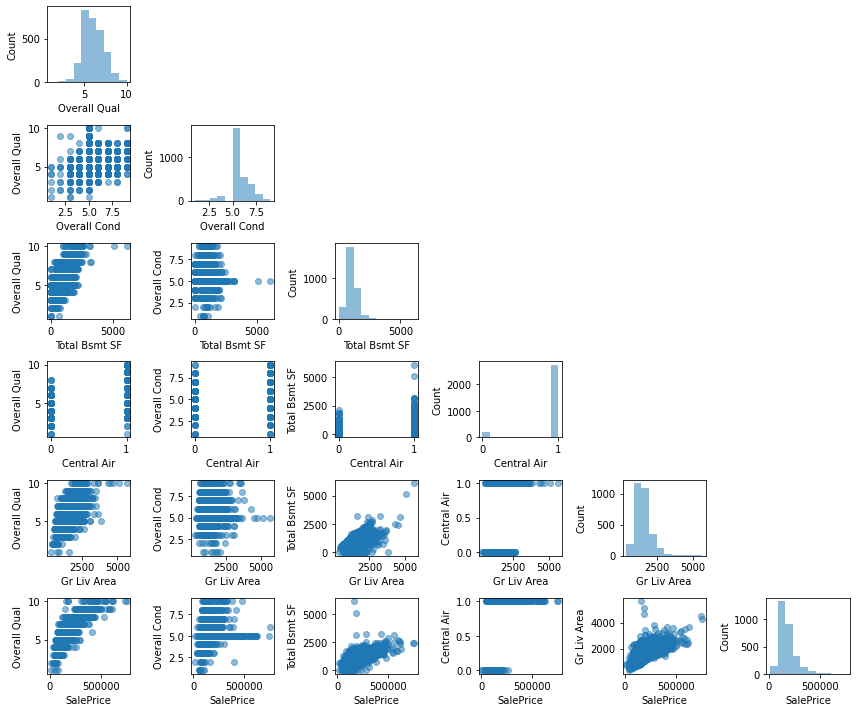

In [13]:
scatterplotmatrix(df.values, figsize=(12, 10), names=df.columns, alpha=0.5)
plt.tight_layout()
plt.show() 

This is a nice overview of the data set characteristics. We have an overview of the data distribution and whether there are outliers. For example, we can see (fifth column from the left of the bottom row) that there is a somewhat linear relationship between the size of the living area above ground (Gr Liv Area) and the sale price (SalePrice). We can see a few outliers (isolated data pairs) in the Gr Liv Area vs SalePrice plot. The overall qual is severely unbalance, with many more '1' records than '0'. SalePrice distribution is somewhat skewed. 

We can also obtain an overview of the data characeristics with a heatmap, to see correlations between attributes

In [14]:
import numpy as np

In [15]:
from mlxtend.plotting import heatmap

In [16]:
cm = np.corrcoef(df.values.T)

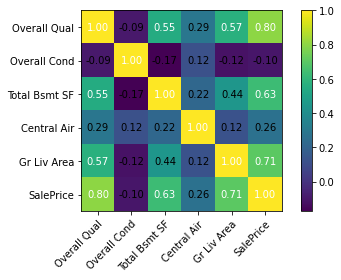

In [17]:
hm = heatmap(cm, row_names=df.columns, column_names=df.columns)
plt.tight_layout()
plt.show()

The largest corellation between an input attribute and the outcome (SalePrice) is observed in the case of Gr Liv Area. Let's keep this one for a simple univariate linear regression. 
To fit a linear regression model, we are interested in those features that have a high correlation with our target variable, SalePrice. Looking at the previous correlation matrix, we can see that SalePrice shows the largest correlation with the Gr Liv Area variable (0.71), which seems to be a good choice for an exploratory variable to introduce the concepts of a simple linear regression model in the following section.

# Applying Linear Regression - Iterative Solution

We will employ a version of iterative OLS (Ordinary least squares) regression. This is defined below. This solves linear regression as a Gradient Descent (GD) optimisation problem. Check more details at: 
https://www.cs.umd.edu/class/fall2019/cmsc426-0201/files/25_GradDescent.pdf

In [18]:
class LinearRegressionGD:
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.array([0.])
        self.losses_ = []
        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta * 2.0 * errors.mean()
            loss = (errors**2).mean()
            self.losses_.append(loss)
        return self
    def net_input(self, X):
        return np.dot(X, self.w_) + self.b_
    def predict(self, X):
        return self.net_input(X)

Next, we keep Gr Liv Area as the input attribute for the linear regression. The output attribute is the SalePrice. 

In [19]:
X = df[['Gr Liv Area']].values
y = df['SalePrice'].values

We will normalse the attributes by removing the mean and scale them to unit variance. Standardisation of data attributes before using machine learning is common and in most cases leads to better performance, reducing the impact that very diverse scales on employed attributes may have in machine learning outcmes. If you have not installed the scikit-learn machine learning library already, do so at the command prompt: 
pip install scikit-learn
or use
pip install -U scikit-learn
for updating it

In [20]:
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()

Now we are ready to perform a linear regression fit on the data

In [21]:
lr = LinearRegressionGD(eta=0.1)

In [22]:
lr.fit(X_std, y_std)

Note the details about using y_std, np.newaxis and flatten. 
While data preprocessing in scikit-learn expect data to be stored in two-dimensional arrays. In the previous example, the use of np.newaxis in "y[:, np.newxis]" added a further dimension to the array. Then, after StandardScaler returned the scaled variable, we converted it back to the original one-dimensional array flatten() method for our convenience. This helps us to observe how the 'loss' function (the employed performance metric) is minimised over time (over iterations, called 'EPOCHs'). 

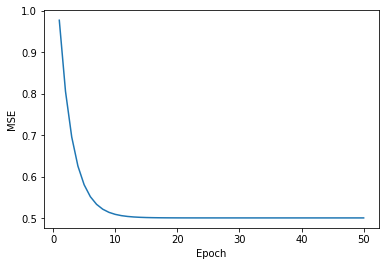

In [23]:
plt.plot(range(1, lr.n_iter+1), lr.losses_)
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.show()

Note that there is very limited improvement beyond 15 epochs or so

Let's take a look at how well the linear regression fits the data

In [24]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=2)

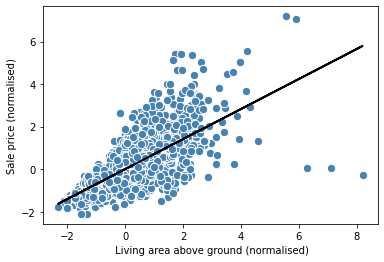

In [25]:
lin_regplot(X_std, y_std, lr)
plt.xlabel(' Living area above ground (normalised)')
plt.ylabel('Sale price (normalised)')
plt.show()

The linear regression line follows the general trend in the day, but is not a very good fit of the data. There are also several data outliers. Note that the plot does not show the attributes in their original scales. Let's convert them back. If we want to use the model to predict/estimate a house price, we better do so in the original scale: 

In [26]:
feature_std = sc_x.transform(np.array([[2500]]))
target_std = lr.predict(feature_std)
target_reverted = sc_y.inverse_transform(target_std.reshape(-1, 1))
print(f'Sales price: ${target_reverted.flatten()[0]:.2f}')

Sales price: $292507.07


Note that we employed an iterative machine lerning solution for linear regression. We could have applied also an analytical solution. The analytical solution will identify the optimal solution. However, this could be prohitively complext for large data sets. 

# Robust Regression - RANSAC

Linear regression becomes problematc in the presence of ouliers, which can have a big effect on how the model's parameters are adjusted in iterative manner. Robust regression methods can be used instead. Next we use the algorithm RANdom SAmple Consensus (RANSAC), after excluding the outliers. Basically it works as follows: 
Start with random sample of data and fit the model - call them inliers. 
Test the learned model with all data points - those with larger errors compared to the threshold are excluded from the 'inlier' set and the model is refit with the updated inliers. 
Next the error is estimated over the inliers and the iterative process continues until either a fixed number of iterations is reached, or a lower error threshold is achieved. This can be seen in the definition below: 

In [27]:
from sklearn.linear_model import LinearRegression, RANSACRegressor

In [28]:
ransac = RANSACRegressor(estimator=LinearRegression(), 
                         max_trials=100, 
                         min_samples=0.95, 
                         residual_threshold=None, 
                         random_state=123)

In [29]:
ransac.fit(X, y)

RANSACRegressor(estimator=LinearRegression(), min_samples=0.95,
                random_state=123)

Maximum number of iterations = 100
Use 95% of data as inliers
The algorithm by default employed mediam absolute deviation (MAD estimate) to select the linerar threshold
Now instead of a random selection of inliers/outliers, we can select them on the basis of the linear fit: 

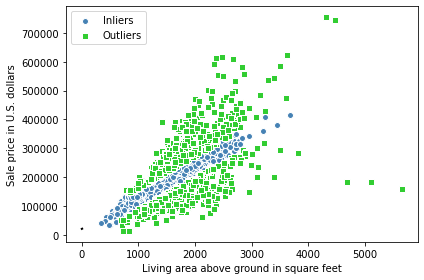

In [30]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],
             c='steelblue', edgecolor='white',
             marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
             c='limegreen', edgecolor='white',
             marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='black', lw=2)
plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in U.S. dollars')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

This excludes too many data points as outliers. We can set the threshold so that this is achieved. 

In [31]:
ransac = RANSACRegressor(estimator=LinearRegression(), 
                         max_trials=100, 
                         min_samples=0.95, 
                         residual_threshold=65000, 
                         random_state=123)

In [32]:
ransac.fit(X, y)

RANSACRegressor(estimator=LinearRegression(), min_samples=0.95,
                random_state=123, residual_threshold=65000)

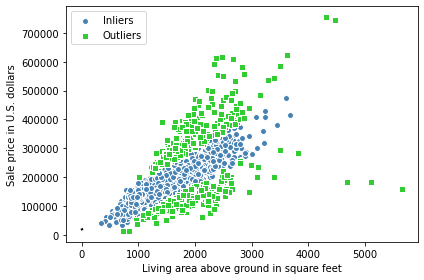

In [33]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],
             c='steelblue', edgecolor='white',
             marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
             c='limegreen', edgecolor='white',
             marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='black', lw=2)
plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in U.S. dollars')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [34]:
ransac = RANSACRegressor(estimator=LinearRegression(), 
                         max_trials=100, 
                         min_samples=0.95, 
                         residual_threshold=170000, 
                         random_state=123)

In [35]:
ransac.fit(X, y)

RANSACRegressor(estimator=LinearRegression(), min_samples=0.95,
                random_state=123, residual_threshold=170000)

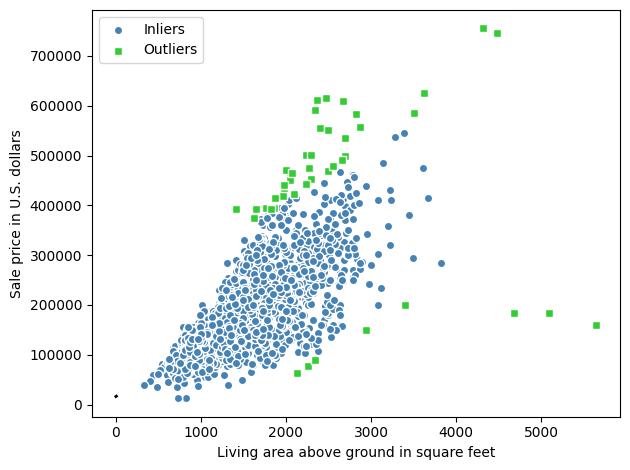

In [82]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],
             c='steelblue', edgecolor='white',
             marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
             c='limegreen', edgecolor='white',
             marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='black', lw=2)
plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in U.S. dollars')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Performance assessment

So far we applied regression on the complete dataset. However, it is better practice to use part of the data for training and part for indepedent validation/testing. This is how it is done. Note that this time we will make use of ALL predictor attributes, not just the single one as before - so we have multivariate linear regression. 

In [36]:
from sklearn.model_selection import train_test_split
target = 'SalePrice'
features = df.columns[df.columns != target]
X = df[features].values
y = df[target].values
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.3, random_state=123) 
slr = LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

Index(['Overall Qual', 'Overall Cond', 'Total Bsmt SF', 'Central Air',
       'Gr Liv Area'],
      dtype='object')


As we now use multivariate data, 2D plots of inputs / outputs are not applicable. But we can still visualise results through a residuals (errors) 2D plot.

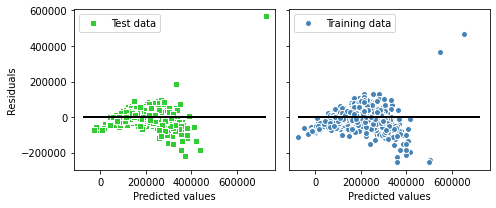

In [37]:
x_max = np.max([np.max(y_train_pred), np.max(y_test_pred)])
x_min = np.min([np.min(y_train_pred), np.min(y_test_pred)])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3), sharey=True)
ax1.scatter(
            y_test_pred, y_test_pred - y_test,
            c='limegreen', marker='s',
            edgecolor='white',
            label='Test data')
ax2.scatter(
            y_train_pred, y_train_pred - y_train,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')
ax1.set_ylabel('Residuals')
for ax in (ax1, ax2):
        ax.set_xlabel('Predicted values')
        ax.legend(loc='upper left')
        ax.hlines(y=0, xmin=x_min-100, xmax=x_max+100,\
        color='black', lw=2)
plt.tight_layout()
plt.show() 

A perfect fit would result in 0 residuals, so clearly we don't have a perfect fit. But we can employ quantitative metrics to assess how good a fit was achieved. We will employe the Mean Squared Error (MSE) over both the training and the test sets. 

In [38]:
from sklearn.metrics import mean_squared_error
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print(f'MSE train: {mse_train:.2f}')
print(f'MSE test: {mse_test:.2f}')

MSE train: 1497216245.85
MSE test: 1516565821.00


We can also estimate the Mean Absolute Error (MAE)

In [39]:
from sklearn.metrics import mean_absolute_error
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
print(f'MAE train: {mae_train:.2f}')
print(f'MAE test: {mae_test:.2f}')

MAE train: 25983.03
MAE test: 24921.29


Note that although MSE is considered a more appropriate performance metric overall, the MAE gives us a more real feeling of the magnitude of the estimation/prediction error. 

We can also report the R2 metric: 

In [40]:
from sklearn.metrics import r2_score
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
print(f'R^2 train: {train_r2:.3f}, R^2 test: {test_r2:.3f}')

R^2 train: 0.769, R^2 test: 0.752


# Overfit control through regularisation

When employing optimisation type of learning, it is possible to penalise overly complex models by adding a complexity penalty term in the cost (loss) function that is to be optimised. The original loss function is for example the sum of squared errors. One approach that employs regularisation is called Ridge Regression. Penalties can apply in different ways in ridge regression. For example level 1 penalties (L1 - absolute) and level 2 penalities (L2 - squaerd) can apply to the model complexity. Regularised regression options are listed below: 

In [42]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0)

Ridge()

In [43]:
from sklearn.linear_model import ElasticNet
elanet = ElasticNet(alpha=1.0, l1_ratio=0.5)

In [44]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=1.0)

The elasticnet descents into Lasso if ratio is 1.0. It descends into Ridge, if ratio = 0.